In [5]:
!pip install pytrends
!pip install pytrendsdaily
!pip install statsmodels

In [44]:
from pytrends import dailydata
import datetime
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pytrends.request import TrendReq
from pytrendsdaily import getDailyData
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline
import seaborn as sns 
sns.set()

In [7]:
def get_data(trends_list, date_range, geo):
  df = []
  for trend in trends_list:
    trends = dailydata.get_daily_data(trend, date_range[2], date_range[0], date_range[5], date_range[3], geo=geo)
    df.append(trends[trend])
    data = pd.DataFrame(df).T
  return data

trends_list = ['Pizza', 'Sushi'] ## кладем в список любой тренд
date_range = [1, 1, 2015, 5, 20, 2021] ## дату указываем в формате мес/день/год
data = get_data(trends_list, date_range, 'RU')

Pizza:2015-01-01 2015-01-31
Pizza:2015-02-01 2015-02-28
Pizza:2015-03-01 2015-03-31
Pizza:2015-04-01 2015-04-30
Pizza:2015-05-01 2015-05-31
Pizza:2015-06-01 2015-06-30
Pizza:2015-07-01 2015-07-31
Pizza:2015-08-01 2015-08-31
Pizza:2015-09-01 2015-09-30
Pizza:2015-10-01 2015-10-31
Pizza:2015-11-01 2015-11-30
Pizza:2015-12-01 2015-12-31
Pizza:2016-01-01 2016-01-31
Pizza:2016-02-01 2016-02-29
Pizza:2016-03-01 2016-03-31
Pizza:2016-04-01 2016-04-30
Pizza:2016-05-01 2016-05-31
Pizza:2016-06-01 2016-06-30
Pizza:2016-07-01 2016-07-31
Pizza:2016-08-01 2016-08-31
Pizza:2016-09-01 2016-09-30
Pizza:2016-10-01 2016-10-31
Pizza:2016-11-01 2016-11-30
Pizza:2016-12-01 2016-12-31
Pizza:2017-01-01 2017-01-31
Pizza:2017-02-01 2017-02-28
Pizza:2017-03-01 2017-03-31
Pizza:2017-04-01 2017-04-30
Pizza:2017-05-01 2017-05-31
Pizza:2017-06-01 2017-06-30
Pizza:2017-07-01 2017-07-31
Pizza:2017-08-01 2017-08-31
Pizza:2017-09-01 2017-09-30
Pizza:2017-10-01 2017-10-31
Pizza:2017-11-01 2017-11-30
Pizza:2017-12-01 201

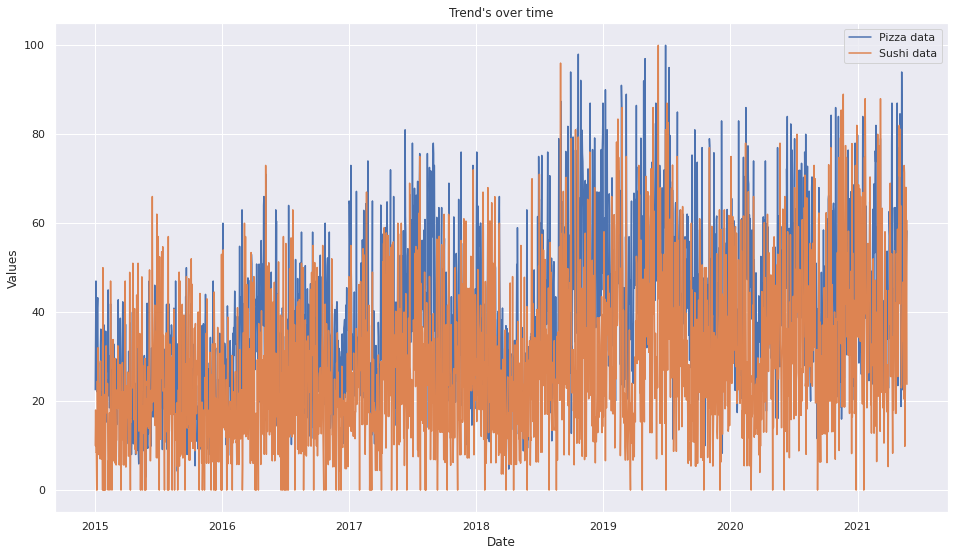

In [8]:
plt.figure(figsize=(16, 9))
for i in data.columns:
  plt.plot(data[i].index, data[i].values, label="{} data".format(i))
  plt.xlabel('Date')
  plt.ylabel('Values')
  plt.title("Trend's over time")
plt.legend()

In [10]:
train_size = int(data.shape[0] * 0.8)
train_df = data.iloc[:train_size]
test_df = data.iloc[train_size:]

In [11]:
print(f'Размер тренирочного датасета {train_df.shape}')
print(f'Размер тестового датасета {test_df.shape}')

Размер тренирочного датасета (1868, 2)
Размер тестового датасета (467, 2)


In [12]:
print(f'Минимальная дата в тренировочном наборе данных {train_df.index.min()}')
print(f'Максимальная дата в тренировочном наборе данных {train_df.index.max()}')
print(f'Минимальная дата в тестовом наборе данных {test_df.index.min()}')
print(f'Максимальная дата в тестовом наборе данных {test_df.index.max()}')

Минимальная дата в тренировочном наборе данных 2015-01-01 00:00:00
Максимальная дата в тренировочном наборе данных 2020-02-11 00:00:00
Минимальная дата в тестовом наборе данных 2020-02-12 00:00:00
Максимальная дата в тестовом наборе данных 2021-05-23 00:00:00


In [13]:
def jarque_bera_test(data):
  for data_c in data.columns:
    col = data[data_c]
    row =  [u'JB', u'p-value', u'skew', u'kurtosis']
    jb_test = sm.stats.stattools.jarque_bera(col)
    a = np.vstack([jb_test])
    itog = sm.iolib.table.SimpleTable(a, row)
    print(itog)
jarque_bera_test(data)

        JB                p-value                skew             kurtosis     
-------------------------------------------------------------------------------
150.57890075269552 2.0054283773087682e-33 0.6219683151562525 2.9818973469581853
-------------------------------------------------------------------------------
        JB               p-value                skew             kurtosis     
------------------------------------------------------------------------------
263.5547220838639 5.8859864734661185e-58 0.7962970448801262 3.4154006463136706
------------------------------------------------------------------------------


In [33]:
def stationary(data):
  for data_c in data.columns:
    col = data[data_c]
    test = sm.tsa.adfuller(col)
    print(data_c)
    print ('adf: ', test[0]) 
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
        data1diff = col.diff(periods=1).dropna()
    else:
        print ('единичных корней нет, ряд стационарен')
stationary(data)

Pizza
adf:  -3.606387931255483
p-value:  0.0056400720130414155
Critical values:  {'1%': -3.4331877074299406, '5%': -2.862793637974449, '10%': -2.5674373678364164}
единичных корней нет, ряд стационарен
Sushi
adf:  -4.69814483861161
p-value:  8.483065413133888e-05
Critical values:  {'1%': -3.4331877074299406, '5%': -2.862793637974449, '10%': -2.5674373678364164}
единичных корней нет, ряд стационарен


[]

In [39]:
def p_value(data):
  for data_c in data.columns:
    col = data[data_c]
    m = col.index[len(col.index)//2+1]
    r1 = sm.stats.DescrStatsW(col[m:])
    r2 = sm.stats.DescrStatsW(col[:m])
    print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])
p_value(data)

p-value:  1.3924387561264754e-98
p-value:  1.4370644406563707e-42


In [45]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [48]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      for data_c in data.columns:
        col = data[data_c]
        mod = sm.tsa.statespace.SARIMAX(col,
        order=param,
        seasonal_order=param_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:24088.118587297067
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:22971.002852066325
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:22349.1662282588
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:21870.37336866599
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:20532.95906434392
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:21139.021984948376
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:19206.145332472443
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:19652.76389412111
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:20410.573238156758
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:20863.541299813456
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:19307.093723648748
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:19717.434560001537
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19995.075691642764
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:20449.350314547977
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19206.281908951005
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19654.02336586982
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:22280.44014066765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:21801.248768687372

# ARIMA ver.2

predicted=50.388348, expected=63.640000
predicted=50.492224, expected=70.520000
predicted=53.093425, expected=61.920000
predicted=51.613427, expected=86.000000
predicted=58.935260, expected=50.740000
predicted=50.481395, expected=50.740000
predicted=50.505637, expected=50.740000
predicted=50.528454, expected=47.300000
predicted=49.583851, expected=76.540000
predicted=57.663518, expected=77.400000
predicted=58.977118, expected=69.660000
predicted=57.846093, expected=68.800000
predicted=58.297503, expected=42.140000
predicted=51.329428, expected=61.920000
predicted=56.432850, expected=45.580000
predicted=52.135378, expected=61.060000
predicted=56.148665, expected=51.600000
predicted=53.771954, expected=49.880000
predicted=53.178417, expected=46.620000
predicted=52.091363, expected=38.480000
predicted=49.515383, expected=58.460000
predicted=54.536799, expected=39.220000
predicted=49.380313, expected=50.320000
predicted=51.954562, expected=35.520000
predicted=47.749371, expected=59.200000


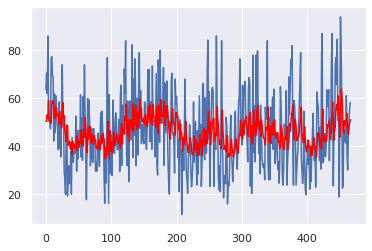

predicted=34.043955, expected=17.160000
predicted=30.657485, expected=46.800000
predicted=33.997471, expected=78.000000
predicted=39.100166, expected=41.340000
predicted=36.160578, expected=19.500000
predicted=33.420615, expected=17.160000
predicted=32.332040, expected=5.460000
predicted=29.852537, expected=28.860000
predicted=31.814450, expected=11.700000
predicted=29.235397, expected=12.480000
predicted=28.360382, expected=67.080000
predicted=35.215550, expected=20.280000
predicted=30.409212, expected=31.980000
predicted=31.485436, expected=5.460000
predicted=27.829321, expected=39.000000
predicted=31.252119, expected=44.460000
predicted=32.460623, expected=24.180000
predicted=30.318919, expected=25.740000
predicted=30.202506, expected=0.000000
predicted=26.384253, expected=8.580000
predicted=26.072094, expected=21.120000
predicted=26.839307, expected=16.500000
predicted=25.850589, expected=17.160000
predicted=25.394818, expected=41.580000
predicted=28.401598, expected=20.460000
pred

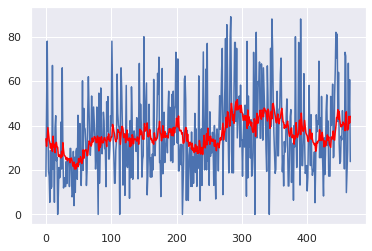

In [47]:
# ARIMA модель
def model_df(data):
  # загрузка датасета
  for data_c in data.columns:
      col = data[data_c]
      # split into train and test sets
      series = col
      # разделение выборки на тренировочную и тестовую
      X = series.values
      size = int(len(X) * 0.8)
      train, test = X[0:size], X[size:len(X)]
      history = [x for x in train]
      predictions = list()
      # валидация
      for t in range(len(test)):
	      model = sm.tsa.ARIMA(history, order=(1,1,1))
	      model_fit = model.fit()
	      output = model_fit.forecast()
	      yhat = output[0]
	      predictions.append(yhat)
	      obs = test[t]
	      history.append(obs)
	      print('predicted=%f, expected=%f' % (yhat, obs))
      # подсчет прогноза
      rmse = sqrt(mean_squared_error(test, predictions))
      print('Test RMSE: %.3f' % rmse)
      # график прогноза и фактических данных
      plt.plot(test)
      plt.plot(predictions, color='red')
      plt.show()
model_df(data)

In [26]:
model_df(trends_list, train_df, test_df)

NameError: ignored

In [ ]:
lstm_model = keras.Sequential([
                               keras.layers.LSTM(32, return_sequences=False),
                               keras.layers.Dense(1)
])